In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import datetime
from operator import add
from numpy import where
from sklearn.datasets import make_classification
from matplotlib import pyplot

In [2]:
data = pd.read_csv('ecommerce-data/data.csv', encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

In [3]:
# Drop the rows that don't have and entry for the CustomerId field
rows_nan = data[data.isnull().T.any().T]
data = data.dropna(subset=["CustomerID"])

# Dropping duplicate rows
duplicated_data = data[data.duplicated(keep=False)]
data.drop_duplicates(inplace=True)

In [4]:
# Clean cancelled orders and descounts
df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break 
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

cleanedData = df_cleaned.copy(deep=True)

In [5]:
# Base Assumption: In a general population, majority of the people would be medium-risk takers, while the outliers would 
# represent either low or high risk takers. The distrbution of people should follow an approximate bell-shaped curve

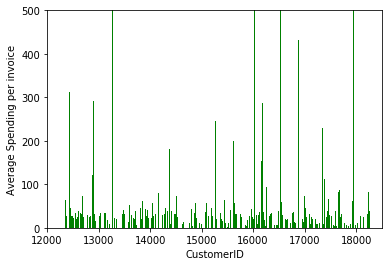

In [6]:
# Assumption: Consumers buying bulk items togeather are implulsive, and hence have a more risk-taking nature
grp = cleanedData.groupby('CustomerID')
avgSpending = dict()
for index,item in grp:
    mean = grp.get_group(index).mean(skipna=True, numeric_only=True) 
    avgSpending[int(index)] = round(mean['Quantity'] * mean['UnitPrice'])
plt.bar(list(avgSpending.keys()), avgSpending.values(), color='g')
plt.ylim(0,500)
plt.xlim(12000, 18500)
plt.xlabel('CustomerID')
plt.ylabel('Average Spending per invoice')
plt.show()
# Conclusion: Most of the bars are small or medium in size, representing low and medium risk-takers respectively
# There are some exceptionally tall bars, denoting the high-risk takers. The assumption is further supported by the distrbution
# of the bars of various sizes.

In [ ]:
# Assumption: Customers with longer duration between purchases have a more risky behaviour as they tend to wait
# for the last moment to accomplish stuff
dataDict = dict()
avgTimeBetweenBuys = {}
for index,item in grp:
    dates = grp.get_group(index).drop_duplicates(subset=['InvoiceNo'], keep='first')
    if len(dates.index > 1):
        diff = [datetime.datetime.strptime(dates.iat[i, 4], '%m/%d/%Y %H:%M') - datetime.datetime.strptime(dates.iat[i - 1, 4], '%m/%d/%Y %H:%M') for i in range(len(dates.index)) if i > 0]
        diffs = [x.total_seconds() for x in diff]
        if len(diffs) > 0:
            dataDict[max(diff).total_seconds()] = sum(diffs) / len(diffs)
            avgTimeBetweenBuys[int(index)] = sum(diffs) / len(diffs)
fig, ax = plt.subplots()
ax.scatter(dataDict.keys(), dataDict.values())
ax.set_xlabel('Maximum time between consicutive buys')
ax.set_ylabel('Average time between consicutive buys')
plt.show()
# Conclusion: The dots lying at the top-right corner of the plot, as well as to some extent the ones in the bottom-right corner
# represent high-risk takers, as they either have a high avg as well as max delay between two invoices(top-right corner), or 
# a high max delay between two invoices(bottom-right corner)

In [ ]:
# Assumption: Consumers buying the same item over and over again are less risk taking in nature
freqDict = dict()
for index,item in grp:
    invoice_count = grp.get_group(index).duplicated(subset=['InvoiceNo']).sum()
    # print(invoice_count)
    # data = grp.get_group(index).groupby(by=["StockCode"]).count().sort_values('InvoiceNo', ascending=False)
    group = grp.get_group(index)
    duplicates = group[group.duplicated(subset=["StockCode"], keep=False)].groupby(by=["StockCode"]).count()['InvoiceNo']
    if len(duplicates) > 0:
        freqDict[int(index)] = float(invoice_count) / float(sum(duplicates))
plt.bar(list(freqDict.keys()), freqDict.values(), color='g')
plt.ylim(0,40)
plt.xlim(12000, 18500)
plt.xlabel('CustomerID')
plt.ylabel('1 / Chances of buying same items')
plt.show()
# Conclusion: Most of the bars are small or medium in size, representing low and medium risk-takers respectively
# There are some exceptionally tall bars, denoting the high-risk takers. The assumption is further supported by the distrbution
# of the bars of various sizes.

In [ ]:
# Assumption: People which buy items with higher unit Prices are probably more risk taking in nature
meanUnitPrice = cleanedData['UnitPrice'].mean()
maxUnitPrice = cleanedData['UnitPrice'].max()
# cleanedData.boxplot(column='UnitPrice')
# Let us assume that the products with top 1% unit Prices in the distrbution can be assumed as expensive
priceLimit = np.percentile(cleanedData['UnitPrice'], 99)
percentageOverspent = dict()
for index, item in grp:
    uniqueProducts = grp.get_group(index).drop_duplicates(subset=['StockCode'], keep='first')
    overspentCount = len(uniqueProducts[uniqueProducts['UnitPrice'] > priceLimit])
    if(overspentCount != 0):
        percentageOverspent[int(index)] = overspentCount / float(len(uniqueProducts))
plt.bar(list(percentageOverspent.keys()), percentageOverspent.values(), color='g')
plt.ylim(0,0.35)
plt.xlim(12000, 18500)
plt.xlabel('CustomerID')
plt.ylabel('% of expensive items bought')
plt.show()
# Conclusion: Most of the bars are small or medium in size, representing low and medium risk-takers respectively
# There are some exceptionally tall bars, denoting the high-risk takers. The assumption is further supported by the distrbution
# of the bars of various sizes.

In [ ]:
# Converting Observations into Probablities
# Basic Assumption: Among all the users, around 15% are low-risk takers, 15% are high-risk takers, and the rest 60% of the
# people are medium risk takers
# Assumption: ALl the 4 parameters calculated above have equal weightage when it comes to determining the final probablity

weight = [0.25] * 4
user_probablity = {}
total_users = len(grp)

# Probablities based on average spending
limits = np.percentile(list(avgSpending.values()), [15, 85])
for key, item in avgSpending.items():
    user_probablity[key] = [weight[0] * int(int(item) <= limits[0]), weight[0] * int(int(item) <= limits[1] and int(item) > limits[0]), weight[0] * int(int(item) > limits[1])]

# Adding probablities based on longer duration between purchases
limits = np.percentile(list(avgTimeBetweenBuys.values()), [15, 85])
for key, item in avgTimeBetweenBuys.items():
    new_list = [weight[1] * int(int(item) <= limits[0]), weight[1] * int(int(item) <= limits[1] and int(item) > limits[0]), weight[1] * int(int(item) > limits[1])]
    if key in user_probablity.keys():
        prev_list = user_probablity[key]
        user_probablity[key] = [prev_list[i] + new_list[i] for i in range(len(prev_list))]
    else:
        user_probablity[key] = new_list
        
# Adding probablities based on buying the same item over and over again
limits = np.percentile(list(freqDict.values()), [15, 85])
for key, item in freqDict.items():
    new_list = [weight[2] * int(int(item) <= limits[0]), weight[2] * int(int(item) <= limits[1] and int(item) > limits[0]), weight[2] * int(int(item) > limits[1])]
    if key in user_probablity.keys():
        prev_list = user_probablity[key]
        user_probablity[key] = [prev_list[i] + new_list[i] for i in range(len(prev_list))]
    else:
        user_probablity[key] = new_list
        
# Adding probablities based on big bucket prices
limits = np.percentile(list(percentageOverspent.values()), [15, 85])
for key, item in percentageOverspent.items():
    new_list = [weight[3] * int(int(item) <= limits[0]), weight[3] * int(int(item) <= limits[1] and int(item) > limits[0]), weight[3] * int(int(item) > limits[1])]
    if key in user_probablity.keys():
        prev_list = user_probablity[key]
        user_probablity[key] = [prev_list[i] + new_list[i] for i in range(len(prev_list))]
    else:
        user_probablity[key] = new_list
        
for key, item in user_probablity.items():
    user_probablity[key] = np.argmax(np.array(user_probablity[key]))

high_risk_customer_id = [key for key, item in user_probablity.items() if item == 2]
low_risk_customer_id = [key for key, item in user_probablity.items() if item == 0]
medium_risk_customer_id = [key for key, item in user_probablity.items() if item == 1]

# Display a pie-chart corrosponding to the % of users
labels = 'Low-Risk', 'Medium-Risk', 'High-Risk'
sizes = [(len(low_risk_customer_id) * 100) / total_users, (len(medium_risk_customer_id) * 100) / total_users, (len(high_risk_customer_id) * 100) / total_users]
explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# Generating data for applying clustering algorithms

data_frame = pd.DataFrame(columns=['averageSpending', 'Duration Between Purchases', 'Same Item Over and Over', 'Big Bucket Price'], index=list(map(int, grp.groups.keys())))
for key, item in avgSpending.items():
    data_frame.ix[key]['averageSpending'] = item
for key, item in avgTimeBetweenBuys.items():
    data_frame.ix[key]['Duration Between Purchases'] = item
for key, item in freqDict.items():
    data_frame.ix[key]['Same Item Over and Over'] = item
for key, item in percentageOverspent.items():
    data_frame.ix[key]['Big Bucket Price'] = item
data_frame.fillna(0, inplace=True)

In [ ]:
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

In [ ]:
def print_percentage_of_users_in_clusters(model):
    model.fit(data_frame)
    try:
        yhat = model.predict(data_frame)
    except:
        yhat = model.fit_predict(data_frame)
    clusters = np.unique(yhat)
    list1 = []
    for cluster in clusters:
        row_ix = where(yhat == cluster)
        list1.append((len(row_ix[0]) * 100 / total_users))
    print(list1)

In [ ]:
# Testing various models with 3 clusters: Low, Medium, and High

model = Birch(threshold=0.01, n_clusters=3)
print_percentage_of_users_in_clusters(model)

model = AgglomerativeClustering(n_clusters=3)
print_percentage_of_users_in_clusters(model)

model = KMeans(n_clusters=3)
print_percentage_of_users_in_clusters(model)